STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# VGG-16 on Cifar-10

## Imports

In [1]:
import torch
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# From local helper files
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [6]:
##########################
### CIFAR-10 DATASET
##########################

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

100%|██████████| 170498071/170498071 [00:14<00:00, 12064775.20it/s]


Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])


## Model

In [7]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_3 = torch.nn.Sequential(        
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
          
        self.block_4 = torch.nn.Sequential(   
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),    
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))             
        )
            
        height, width = 3, 3 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)

        return logits, probas 
                                     

In [8]:



def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.001,
                           max_lr=0.006,
                           mode='triangular',
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)

    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    
    if mode == 'triangular':
        pass
    elif mode == 'triangular2':
        lr_delta = lr_delta * 1 / (2. ** (cycle - 1))
    elif mode == 'exp_range':
        lr_delta = lr_delta * (gamma**(batch_step))
    else:
        raise ValueError('mode must be "triangular", "triangular2", or "exp_range"')
        
    lr = base_lr + lr_delta
    
    return lr


In [9]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        logits,probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [12]:
from zmq import PROTOCOL_ERROR_ZAP_BAD_REQUEST_ID
model = VGG16(num_classes=10)

model = model.to(DEVICE)
#################################
### Setting for this run
#################################

num_epochs = 20
iter_per_ep = len(train_loader.sampler.indices) // train_loader.batch_size
base_lr = 0.01
max_lr = 0.1
batch_step=-1

#################################
### Init Model
#################################

torch.manual_seed(RANDOM_SEED)


##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)  

########################################################################
# Collect the data to be evaluated via the LR Range Test
collect = {'epoch': [], 'cost': [], 'train_acc': [], 'val_acc': []}
########################################################################

start_time = time.time()
for epoch in range(num_epochs):
    epoch_avg_cost = 0.
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        batch_step+=1
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits,probas= model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        epoch_avg_cost += cost
        
        #############################################
        # Logging
        if not batch_idx % 20:
              print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')     


    #############################################
    # Collect stats    
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, valid_loader)
    epoch_avg_cost /= batch_idx+1
    collect['epoch'].append(epoch+1)
    collect['val_acc'].append(val_acc)
    collect['train_acc'].append(train_acc)
    collect['cost'].append(epoch_avg_cost / iter_per_ep)
    
    ################################################
    # Logging
    print('Epoch %3d' % (epoch+1), end='')
    print('  |  Train/Valid Acc: %.2f/%.2f' % (train_acc, val_acc))
    
    
    
    #############################################
    # update learning rate
    base_lr = cyclical_learning_rate(batch_step=batch_step,
                                     step_size=num_epochs*iter_per_ep,
                                     base_lr=base_lr,
                                     max_lr=max_lr)
    for g in optimizer.param_groups:
        g['lr'] = base_lr
    ############################################
    

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('base_lr: ', base_lr)
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                        factor=0.1,
#                                                        mode='max',
#                                                        verbose=True)

# minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
#     model=model,
#     num_epochs=NUM_EPOCHS,
#     train_loader=train_loader,
#     valid_loader=valid_loader,
#     test_loader=test_loader,
#     optimizer=optimizer,
#     device=DEVICE,
#     scheduler=scheduler,
#     scheduler_on='valid_acc',
#     logging_interval=100)

# plot_training_loss(minibatch_loss_list=minibatch_loss_list,
#                    num_epochs=NUM_EPOCHS,
#                    iter_per_epoch=len(train_loader),
#                    results_dir=None,
#                    averaging_iterations=200)
# plt.show()

# plot_accuracy(train_acc_list=train_acc_list,
#               valid_acc_list=valid_acc_list,
#               results_dir=None)
# plt.ylim([60, 100])
# plt.show()

Epoch: 001/020 | Batch 000/351 | Cost: 3.7717
Epoch: 001/020 | Batch 020/351 | Cost: 2.3192
Epoch: 001/020 | Batch 040/351 | Cost: 2.2782
Epoch: 001/020 | Batch 060/351 | Cost: 2.2668
Epoch: 001/020 | Batch 080/351 | Cost: 2.1214
Epoch: 001/020 | Batch 100/351 | Cost: 2.1689
Epoch: 001/020 | Batch 120/351 | Cost: 2.1165
Epoch: 001/020 | Batch 140/351 | Cost: 2.1009
Epoch: 001/020 | Batch 160/351 | Cost: 2.0733
Epoch: 001/020 | Batch 180/351 | Cost: 1.9655
Epoch: 001/020 | Batch 200/351 | Cost: 2.0866
Epoch: 001/020 | Batch 220/351 | Cost: 2.0715
Epoch: 001/020 | Batch 240/351 | Cost: 2.0348
Epoch: 001/020 | Batch 260/351 | Cost: 1.9018
Epoch: 001/020 | Batch 280/351 | Cost: 2.0200
Epoch: 001/020 | Batch 300/351 | Cost: 1.9544
Epoch: 001/020 | Batch 320/351 | Cost: 1.9321
Epoch: 001/020 | Batch 340/351 | Cost: 2.0282
Epoch   1  |  Train/Valid Acc: 33.45/33.54
Time elapsed: 1.72 min
base_lr:  0.014487179487179478
Epoch: 002/020 | Batch 000/351 | Cost: 1.7473
Epoch: 002/020 | Batch 020/35

In [13]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 80.22%


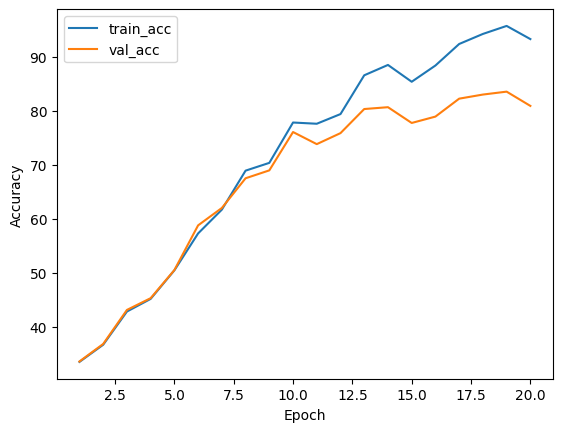

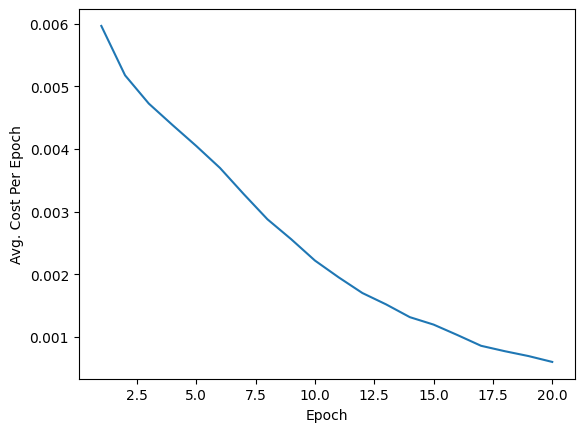

In [14]:
costarr=[collect['cost'][i].item() for i in range(len(collect['cost']))]
trainacc=[collect['train_acc'][i].item() for i in range(len(collect['train_acc']))]
validacc=[collect['val_acc'][i].item() for i in range(len(collect['val_acc']))]

plt.plot(collect['epoch'], trainacc, label='train_acc')
plt.plot(collect['epoch'], validacc, label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(collect['epoch'], costarr)
plt.xlabel('Epoch')
plt.ylabel('Avg. Cost Per Epoch')
plt.show()